## Continuous Wavelat Transform test
Here we apply a CWT to do time-frequency decomposition to a seismogram and then do a simple 
test to cluster the samples

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import obspy as op
from obspy.imaging.cm import obspy_sequential
from obspy.signal.tf_misfit import cwt

## A simple scalogram

This might allow us to differentiate between P and S arrivals in a broadband trace. Might also be useful for noise discrimination

In [3]:
st = op.read('test_98.mseed',format='mseed')

tr = st[0]
npts = tr.stats.npts
dt = tr.stats.delta

#Maybe we need to filter the trace?
#tr = tr.filter('bandpass',freqmin=0.01,freqmax=10)

t = np.linspace(0, dt * npts, npts)
f_min = 0.01
f_max = 5
nf= 100

#obspy ctw
#8 is the tradeoff parameter between frequency and time resolution
#fmin and fmax represent the scales, nf  is the number of frequencies 
#between the two 
scalogram = cwt(tr.data, dt, 8, f_min, f_max,nf)

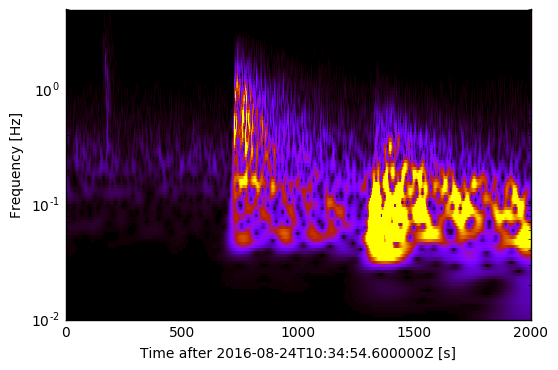

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)

x, y = np.meshgrid(t,np.logspace(np.log10(f_min), np.log10(f_max), scalogram.shape[0]))

ax.pcolormesh(x, y, np.abs(scalogram),cmap='gnuplot',vmin=0,vmax=1000)
ax.set_xlabel("Time after %s [s]" % tr.stats.starttime)
ax.set_ylabel("Frequency [Hz]")
ax.set_yscale('log')
ax.set_ylim(f_min, f_max)
plt.show()

Scalogram clearly shows the P and S wave arrivals in this trace

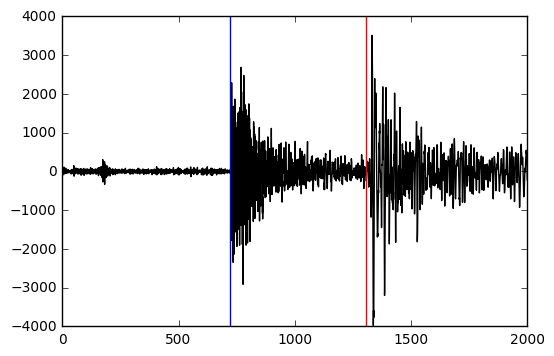

In [5]:
X = np.linspace(0,(tr.stats.endtime-tr.stats.starttime),tr.stats.npts)
plt.plot(X,tr.data,'k')
plt.axvline(x=720,color='b')
plt.axvline(x=1305,color='r')

In [6]:
np.shape(scalogram) #this is a matrix in time-frequency space

(100, 40000)

In [7]:
import pandas as pd

Convert to pandas df for use with SK-Learn

In [8]:
scalogram_df = pd.DataFrame(np.transpose(np.abs(scalogram)))

In [9]:
scalogram_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.078199,0.099966,0.113657,0.117155,0.120003,0.142916,0.187316,0.227192,0.237043,0.222813,...,0.188410,0.134199,0.091459,0.060696,0.040631,0.028695,0.022197,0.018930,0.016857,0.014550
1,0.078227,0.099999,0.113691,0.117179,0.120009,0.142918,0.187345,0.227247,0.237088,0.222781,...,0.196790,0.139932,0.094387,0.061270,0.039716,0.027191,0.020773,0.018102,0.016856,0.015165
2,0.078254,0.100033,0.113725,0.117203,0.120014,0.142921,0.187373,0.227301,0.237132,0.222748,...,0.203380,0.144295,0.096185,0.060806,0.037794,0.024741,0.018483,0.016514,0.016258,0.015341
3,0.078282,0.100066,0.113759,0.117226,0.120019,0.142923,0.187401,0.227356,0.237177,0.222715,...,0.208010,0.147216,0.096882,0.059411,0.035007,0.021504,0.015511,0.014333,0.015182,0.015140
4,0.078309,0.100100,0.113793,0.117250,0.120024,0.142926,0.187429,0.227410,0.237221,0.222683,...,0.210564,0.148677,0.096565,0.057269,0.031587,0.017713,0.012128,0.011828,0.013824,0.014677


## Using Kmeans to cluster the data

In [11]:
from sklearn.cluster import KMeans, MiniBatchKMeans, Birch
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(scalogram_df)
scaled_scalogram = scaler.transform(scalogram_df)

est = KMeans(n_clusters=4,verbose=0)
est.fit(scaled_scalogram)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [12]:
est.labels_

array([0, 0, 0, ..., 3, 3, 3], dtype=int32)

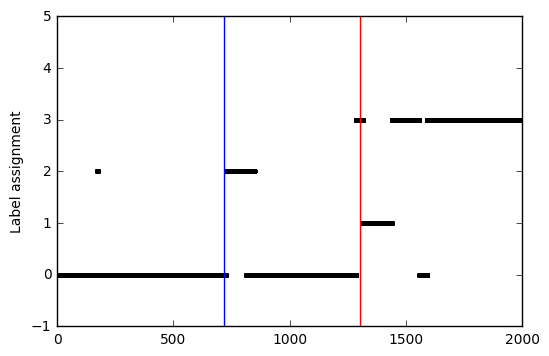

In [13]:

plt.plot(X,est.labels_,'k.')
plt.ylim(-1,5)
plt.ylabel("Label assignment")
plt.axvline(x=720,color='b')
plt.axvline(x=1305,color='r')

MiniBatch K-means: This is musch faster but seems to loose accuracy

In [14]:
est2 = MiniBatchKMeans(n_clusters=4).fit(scaled_scalogram)

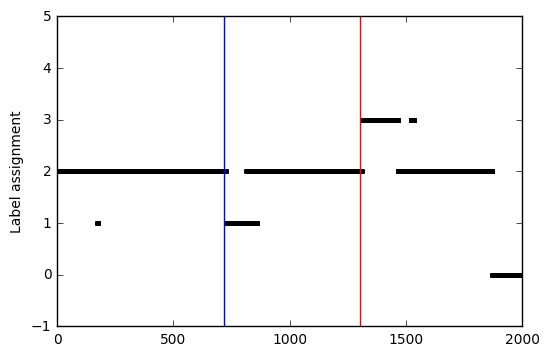

In [15]:
plt.plot(X,est2.labels_,'k.')
plt.ylim(-1,5)
plt.ylabel("Label assignment")
plt.axvline(x=720,color='b')
plt.axvline(x=1305,color='r')

In [16]:
scaled_scalogram_df = pd.DataFrame(scaled_scalogram,columns=scalogram_df.columns)

now we want to reduce the size of the datset by averaging over multiple samples

In [17]:
samp_window = int(1/tr.stats.delta)
ds = np.zeros([int(tr.stats.npts/samp_window),np.shape(scalogram)[0]])
samps = np.shape(ds)[0]

j = 0
for i in range(0,samps):
    slicedf = scalogram_df.iloc[j:j+samp_window]
    j = j + samp_window
    ds[i,:] = slicedf.mean()
    

In [18]:
sampled_df = pd.DataFrame(ds)
sampled_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.078461,0.100284,0.113980,0.117381,0.120051,0.142938,0.187581,0.227709,0.237464,0.222498,...,0.167174,0.122063,0.080805,0.047504,0.024966,0.012716,0.008485,0.008684,0.012032,0.014051
1,0.079013,0.100953,0.114661,0.117856,0.120140,0.142968,0.188124,0.228788,0.238343,0.221804,...,0.047816,0.032045,0.027261,0.026488,0.023759,0.022939,0.023297,0.025083,0.024615,0.021204
2,0.079567,0.101624,0.115342,0.118326,0.120214,0.142975,0.188647,0.229854,0.239209,0.221062,...,0.057126,0.058707,0.051657,0.038850,0.025872,0.021027,0.021915,0.021078,0.017151,0.013188
3,0.080122,0.102295,0.116022,0.118790,0.120271,0.142956,0.189148,0.230906,0.240064,0.220274,...,0.071571,0.051203,0.033925,0.031099,0.029818,0.024903,0.019754,0.015148,0.013109,0.013300
4,0.080679,0.102968,0.116701,0.119251,0.120313,0.142913,0.189629,0.231945,0.240908,0.219439,...,0.067418,0.058531,0.045832,0.033428,0.026994,0.024556,0.019007,0.012799,0.010219,0.010291


In [19]:
est = KMeans(n_clusters=4,verbose=0)
est.fit(sampled_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

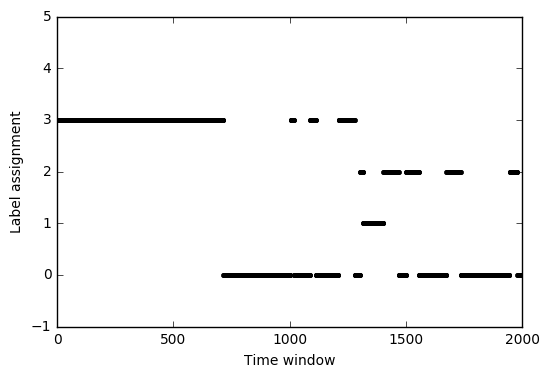

In [20]:
plt.plot(est.labels_,'k.')
plt.ylim(-1,5)
plt.ylabel("Label assignment")
plt.xlabel("Time window")

## A longer timeseries

Lets try this on a longer trace with more noise - the aim here is to be able to distinguish between earthquake and noise

In [43]:
###TAKES A LONG TIME - this is going to be a problem if we decide to use the CWT###

st = op.read('waveforms3/TA.E25K..BHN.M.2016.237.013632.SAC',format='SAC')

tr = st[0]
npts = tr.stats.npts
dt = tr.stats.delta

#Maybe we need to filter the trace?
#tr = tr.filter('bandpass',freqmin=0.01,freqmax=10)

t = np.linspace(0, dt * npts, npts)
f_min = 0.01
f_max = 5
nf= 50

#obspy ctw
#8 is the tradeoff parameter between frequency and time resolution
#fmin and fmax represent the scales, nf  is the number of frequencies 
#between the two 
scalogram = cwt(tr.data, dt, 8, f_min, f_max,nf)

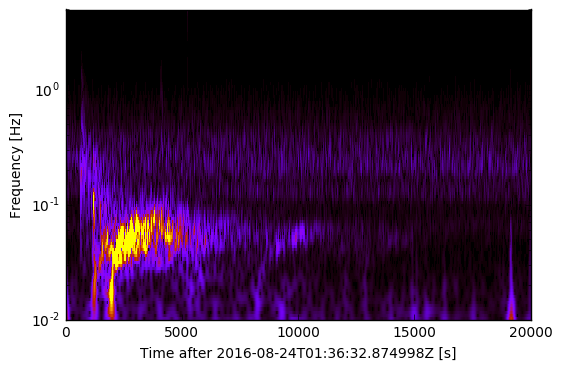

In [70]:
fig = plt.figure()
ax = fig.add_subplot(111)

x, y = np.meshgrid(t,np.logspace(np.log10(f_min), np.log10(f_max), scalogram.shape[0]))

ax.pcolormesh(x, y, np.abs(scalogram),cmap='gnuplot',vmin=0,vmax=1000)
ax.set_xlabel("Time after %s [s]" % tr.stats.starttime)
ax.set_ylabel("Frequency [Hz]")
ax.set_yscale('log')
ax.set_ylim(f_min, f_max)
plt.show()

In [188]:
scalogram_df = pd.DataFrame(np.transpose(np.abs(scalogram)))
scaler = StandardScaler()
scaler.fit(scalogram_df)
scaled_scalogram = scaler.transform(scalogram_df)
scaled_scalogram_df = pd.DataFrame(scaled_scalogram,columns=scalogram_df.columns)

In [189]:
est4 = MiniBatchKMeans(n_clusters=4).fit(scaled_scalogram_df)

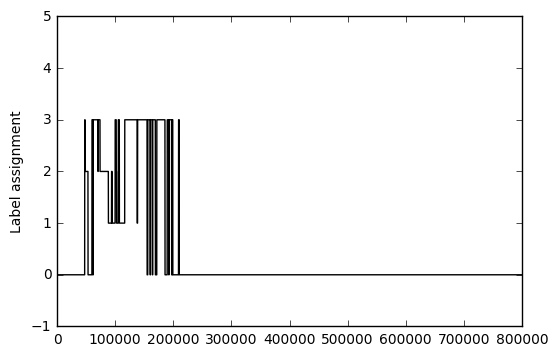

In [190]:
plt.plot(est4.labels_,'k-',markersize=0.5)
plt.ylim(-1,5)
plt.ylabel("Label assignment")

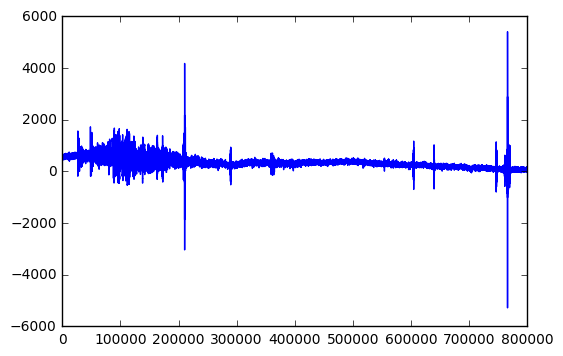

In [191]:
plt.plot(tr.data)

## Attempt to classify using filters - this should be faster

In [28]:
st = op.read('waveforms3/TA.E25K..BHN.M.2016.237.013632.SAC',format='SAC')
tr = st[0]

In [29]:
fbands = [(0.02,0.1),(0.1,0.3),(0.3,0.8),(0.8,1.2),(1,5)]

#One filter doesn't work well, but if we use a set of them the results are
#improved

filter_arr = np.zeros([len(tr.data),len(fbands)])

for i in range(len(fbands)):
    band = fbands[i]
    print band
    trcopy = tr.copy()
    trcopy.filter("bandpass",freqmin=band[0],freqmax=band[1])
    filter_arr[:,i] = np.abs(trcopy.data)
    
    

(0.02, 0.1)
(0.1, 0.3)
(0.3, 0.8)
(0.8, 1.2)
(1, 5)


In [30]:
arr_df = pd.DataFrame(filter_arr)

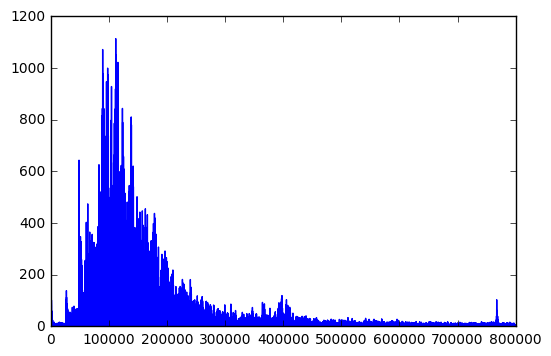

In [31]:
plt.plot(arr_df[0])

In [34]:
#Interestingly, it appears to work better without the scaling applied!
#Could also just normalize the traces

scaler = StandardScaler()
scaler.fit(arr_df)
scaled_arr = scaler.transform(arr_df)
scaled_arr_df = pd.DataFrame(scaled_arr,columns=arr_df.columns)

est5 = KMeans(n_clusters=4).fit(scaled_arr_df)

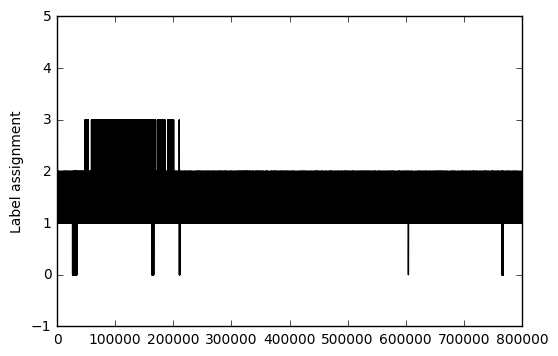

In [35]:
plt.plot(est5.labels_,'k-',markersize=0.5)
plt.ylim(-1,5)
plt.ylabel("Label assignment")

In [36]:
#Using a sample size of 3 seconds - averaging over 3 second blocks

samp_window = int(3/tr.stats.delta)
ds = np.zeros([int(tr.stats.npts/samp_window),np.shape(scaled_arr_df)[1]])
samps = np.shape(ds)[0]

j = 0
for i in range(0,samps):
    slicedf = scaled_arr_df.iloc[j:j+samp_window]
    j = j + samp_window
    ds[i,:] = slicedf.mean()
    

In [37]:
sampled_df = pd.DataFrame(ds)
sampled_df.head()

,0,1,2,3,4
0,-0.370306,0.205702,3.056013,8.374126,10.866149
1,0.608690,2.606606,0.334667,3.482191,0.062908
2,0.896790,2.690583,0.223056,0.657669,-0.120757
3,0.296816,0.984497,0.902185,-0.308274,-0.068700
4,1.538644,-0.107501,-0.185038,0.468616,0.142860


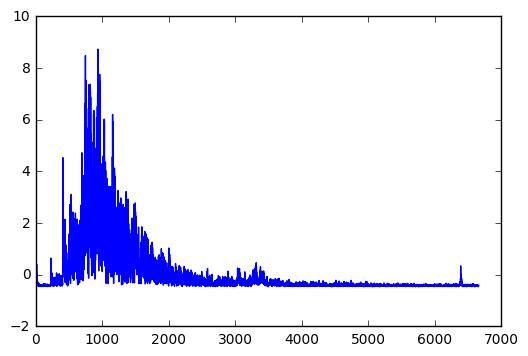

In [38]:
plt.plot(sampled_df[0])

In [39]:
est5 = KMeans(n_clusters=4).fit(ds)

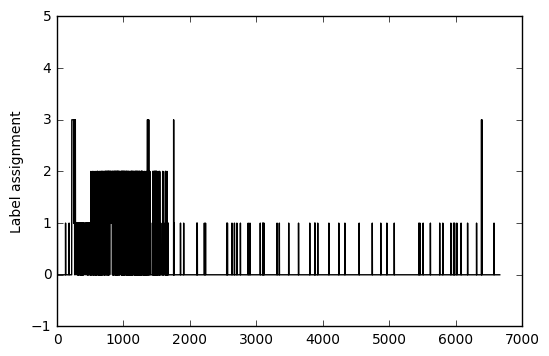

In [40]:
plt.plot(est5.labels_,'k-',markersize=1)
plt.ylim(-1,5)
plt.ylabel("Label assignment")

Seems to vary quite a lot depending on the filters we use - this my not be good